# Empty Lands Tax
Initial goal is to calculate the following:
- Number of vacant A/AMX lots
- Proportion of A/AMX lots that is vacant
- Total vacant land area in A/AMX districts

Assumption: vacant is currently defined as less than $100,000 in building value according to Honolulu real property tax records.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Projection for use in calculating areas
albers_hi = '+proj=aea +lat_0=13 +lon_0=-157 +lat_1=8 +lat_2=18 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +type=crs'

In [2]:
# Shapefile containing all Honolulu zoning areas and development standards
# Source: Hawaii Zoning Atlas c. July 2024 (latest vintage)
zoning = gpd.read_file('./data/zoning_maps/HonoluluCountyHonoluluCountyHI-ZoningDistricts.geojson')

In [3]:
# Only keep columns containing relevant metadata and development standards
keep_cols = ['Abbreviated District Name',
            'Full District Name',
            'Type of Zoning District',
            '1-Family Front Setback',
       '1-Family Front Setback Units', '1-Family Side Setback',
       '1-Family Side Setback Units', '1-Family Rear Setback',
       '1-Family Rear Setback Units',
       '1-Family Max. Lot Coverage - Buildings',
       '1-Family Max. Lot Coverage - Buildings Units',
       '1-Family Max. Lot Coverage - Buildings & Impervious Surface',
       '1-Family Max. Lot Coverage - Buildings & Impervious Surface Units',
       '1-Family Max. Stories',
       '1-Family Max. Stories Units', '1-Family Max. Height',
       '1-Family Max. Height Units',
       '1-Family Floor to Area Ratio', '1-Family Floor to Area Ratio Units',
       '1-Family Min. Unit Size', '1-Family Min. Unit Size Units',
       'geometry'
            ]

zoning = zoning[keep_cols]

# Only keep rows containing 'A-' or 'AMX-'
zoning = zoning[zoning['Abbreviated District Name'].str.contains(r'\b(A-|AMX-)', regex=True)]


C:\Users\curly\AppData\Local\Temp\ipykernel_26536\2549034758.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  zoning = zoning[zoning['Abbreviated District Name'].str.contains(r'\b(A-|AMX-)', regex=True)]


In [4]:
# Shapefile containing Honolulu parcels (not uploaded b/c file too large for Github)
# Source: Statewide GIS portal as of 9/1/2024 https://geoportal.hawaii.gov/datasets/0066cc691254414991182cbda7de4721_0/explore
# mask parameter clips parcels on read, saving ~90s runtime
tax_parcels = gpd.read_file('./local/Honolulu Tax Parcels.geojson', mask=zoning)

In [5]:
tax_parcels.columns

Index(['objectid', 'parcel_uid', 'type', 'tmk', 'taxpin', 'rec_area_ac',
       'rec_area_sf', 'street_parcel', 'zsp', 'in_date', 'in_file_num',
       'in_edit_event', 'parcel_fabric_type', 'zone', 'section', 'plat',
       'rpa_source_doc', 'ias_transaction', 'rpa_spatial_source_doc',
       'rpa_stated_area', 'guid', 'last_edited_date', 'plan_lookup', 'tmk8num',
       'tmk9num', 'globalid', 'CreationDate', 'Creator', 'EditDate', 'Editor',
       'geometry'],
      dtype='object')

In [6]:
tax_parcels.groupby('tmk').groups

{'11012004': [0], '11012012': [1], '11012013': [2], '11012014': [3], '11012026': [4], '11012027': [5], '11012028': [6], '11012029': [9420], '11012032': [7], '11012033': [8], '11012036': [9], '11012037': [10], '11012038': [11], '11012039': [12], '11017001': [13], '11017005': [9219], '11017006': [9226], '11017007': [9220], '11017008': [9227], '11017009': [9228], '11017010': [9221], '11017011': [9222], '11017012': [9223], '11017013': [9229], '11017014': [9230], '11017015': [9224], '11017016': [9225], '11017017': [14], '11017018': [15], '11017019': [9231], '11017020': [16], '11017021': [17], '11017022': [9232], '11017023': [18], '11017024': [19], '11017025': [9233], '11017026': [20], '11017027': [21], '11017028': [9234], '11017029': [22], '11017030': [23], '11017031': [9235], '11017032': [24], '11017033': [25], '11017034': [26], '11017035': [27], '11017036': [28], '11017037': [29], '11017038': [30], '11017039': [9218], '11018001': [31], '11018002': [32], '11018003': [33], '11018004': [34],

In [7]:
# remove duplicates for 1:1 merge
# NOTE I don't know why there were 4 duplicates, check later
tax_parcels.drop_duplicates('tmk', 
                            inplace=True)

In [8]:
# Shapefile containing Honolulu real property tax data (not uploaded b/c file too large for Github)
# FIXME geometry is invalid. If we could fix, tax_parcels would be unnecessary.
# Source: Statewide GIS portal as of 9/1/2024 https://geoportal.hawaii.gov/datasets/11a667cc8ab0434c9c40c8566dc0d375_9/explore
tax_values = gpd.read_file('./local/Honolulu Tax Valuations.geojson')

In [12]:
tax_values.columns

Index(['tmk', 'buildingvalue', 'buildingexemption', 'landvalue',
       'landexemption', 'pittsqft', 'pittacre'],
      dtype='object')

In [11]:
# FIXME instead of dropping geometry, download the file without it if we can't fix it
tax_values.drop('geometry',
                axis = 1,
                inplace=True)

"""
NOTE need to confirm correct understanding with RPAD: Sum all TMK suffixes or exclude 0000?
0000 corresponds to the master record for a condo. The land value is often close to equal to the
sum of all land values for suffixes 1-N. Implies either condo association owns and pays taxes on
50% of the land, or that the land value in the master line *is* the sum.
"""

tax_values = tax_values.groupby('tmk').agg({
        'buildingvalue': 'sum',
        'buildingexemption': 'sum',
        'landvalue': 'sum',
        'landexemption': 'sum'
    }).reset_index()


KeyError: "['geometry'] not found in axis"

In [13]:
tax_values.head()

,tmk,buildingvalue,buildingexemption,landvalue,landexemption,pittsqft,pittacre
0,11001001,9708600,9708600,48259900,48259900,0,0
1,11002001,19600,19600,29235500,29235500,0,0
2,11002002,12041800,12041800,86450600,86450600,0,0
3,11002004,0,0,7407700,7407700,0,0
4,11002006,1350900,1350900,2427200,2427200,0,0


In [14]:
# join tax parcels to tax values on TMK
# FIXME Merge keys are not unique in left dataset; not a one-to-one merge
full_tax_data = tax_parcels.merge(tax_values,
                  how = 'inner',
                  on = 'tmk',
                  validate = '1:1')

In [15]:
full_tax_data.columns

Index(['objectid', 'parcel_uid', 'type', 'tmk', 'taxpin', 'rec_area_ac',
       'rec_area_sf', 'street_parcel', 'zsp', 'in_date', 'in_file_num',
       'in_edit_event', 'parcel_fabric_type', 'zone', 'section', 'plat',
       'rpa_source_doc', 'ias_transaction', 'rpa_spatial_source_doc',
       'rpa_stated_area', 'guid', 'last_edited_date', 'plan_lookup', 'tmk8num',
       'tmk9num', 'globalid', 'CreationDate', 'Creator', 'EditDate', 'Editor',
       'geometry', 'buildingvalue', 'buildingexemption', 'landvalue',
       'landexemption', 'pittsqft', 'pittacre'],
      dtype='object')

In [16]:
parcels_in_zones = full_tax_data.overlay(zoning, how = 'intersection')

<Axes: >

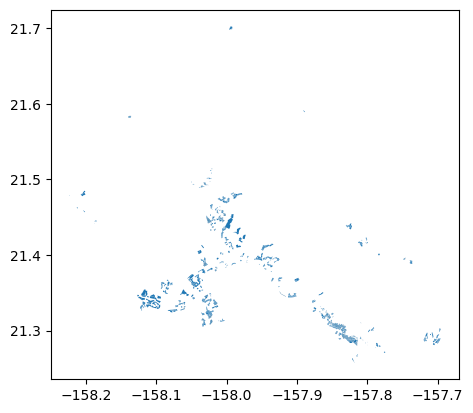

In [17]:
parcels_in_zones.plot()

In [18]:
# filter parcels in zones to <100000 bldg value in new df
filter_value = 100000
vacant_parcels = parcels_in_zones[parcels_in_zones['buildingvalue'] < filter_value]

In [19]:
# calculate proportion of lots and lot area that is vacant
print('number of vacant A/AMX lots: ', len(vacant_parcels))
print('percent of A/AMX lots that are vacant: ', round(len(vacant_parcels)/len(tax_parcels),2))

# FIXME rec_area_ac has a lot of missing data, need to project to albers, calculate our own parcel areas, then redo this calculation
print('percent of total A/AMX land area that is vacant: TBD')
# print('percent of total A/AMX land area that is vacant: ', vacant_parcels.rec_area_ac.sum()/tax_parcels.rec_area_ac.sum())

number of vacant A/AMX lots:  1846
percent of A/AMX lots that are vacant:  0.19
percent of total A/AMX land area that is vacant: TBD
